In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pickle

# Distintos Robots

## Robot de Medias y Bandas de Bollinger

In [2]:
with open("/rentabilidades_MMBBConclusion.pkl", 'rb') as file:
    robot_MMBB = pickle.load(file)
    

## Robot de Q-Learning

In [3]:
with open("/progress_NuevoQLearning.pkl", 'rb') as file:
    general_hist = pickle.load(file)
    

In [4]:
indiv_ret = []
sum_history = general_hist["A"].copy()
indiv_ret.append(general_hist["A"].Capital.iloc[-1] / 22026.431718061674 - 1)
sum_hist_invested= general_hist["A"]["Stock money"].copy().abs()
for df_hist in general_hist:
    if df_hist == "A":
        continue
    if general_hist[df_hist].empty:
        sum_history = sum_history + pd.DataFrame({"Cash": general_hist["A"].Cash * 0 + 22026.431718061674,
                                                  "Stock money": general_hist["A"]["Stock money"] * 0,
                                                  "Capital": general_hist["A"].Capital * 0 + 22026.431718061674})
        indiv_ret.append(22026.431718061674 / 22026.431718061674 - 1)
        continue
        
    sum_history = sum_history + general_hist[df_hist]
    sum_hist_invested = sum_hist_invested + general_hist[df_hist]["Stock money"].abs()
    indiv_ret.append(general_hist[df_hist].Capital.iloc[-1] / 22026.431718061674 - 1)

In [5]:
robot_QLearning = sum_history.Capital

## Robot basado en CAPM

In [6]:
with open("/CAPM_Conclusiones.pkl", 'rb') as file:
    robot_CAPM = pickle.load(file)
    

# Comparativa

In [7]:
def alinear(robot):
    maximo = max(len(robot_MMBB.values), len(robot_QLearning.values), len(robot_CAPM.values))
    return [10000000] * (maximo - len(robot.values)) + list(robot.values)

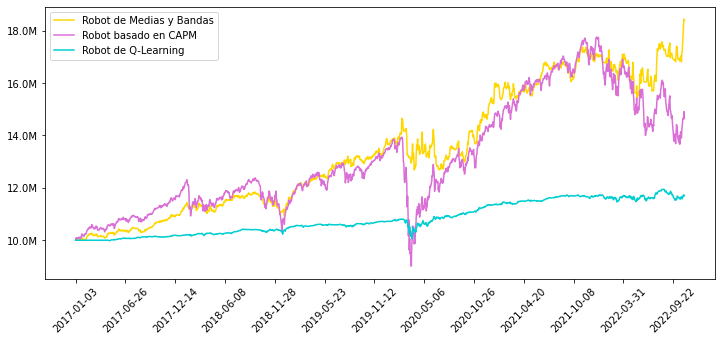

In [8]:
def to_millions(x, pos):
    return f'{x*1e-6:.1f}M'
formatter = mtick.FuncFormatter(to_millions)


plt.figure(figsize = (12, 5))
#plt.plot(SP500.values, label = "S&P 500 Index")
plt.plot(alinear(robot_MMBB), label = "Robot de Medias y Bandas", color = "gold")
plt.plot(alinear(robot_CAPM), label = "Robot basado en CAPM", color = "orchid")
plt.plot(alinear(robot_QLearning), label = "Robot de Q-Learning", color = "darkturquoise")
plt.legend(loc = 'upper left')
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(range(0, len(robot_CAPM), 120), robot_CAPM.index[::120], rotation = 45)
plt.show()


# SP500

In [255]:
# Comparativa con el S&P 500
sp500 = yf.download('^GSPC', start='2017-01-01', end='2022-10-31')

prices = sp500['Close']

daily_return = prices.pct_change()

total_capital = (1 + daily_return).cumprod()
total_capital.iloc[0] = 1

# Rentabilidad Total
total_return = (total_capital.iloc[-1] / total_capital.iloc[0] - 1)
print("Total Return: {:.2f}%".format(total_return * 100))

# Rentabilidad Anualizada
annualized_return = ((total_capital.iloc[-1] / total_capital.iloc[0]) ** (252 / len(total_capital)) - 1) 
print("Annualized Return: {:.2f}%".format(annualized_return * 100))

# Volatilidad
volatility = daily_return.std() * np.sqrt(252)
print("Volatility: {:.2f}%".format(volatility * 100))

# MDD
drawdown = total_capital / total_capital.cummax() - 1
max_drawdown = drawdown.min()
print("Maximum Drawdown: {:.2f}%".format(max_drawdown * 100))

# Sharpe Ratio
daily_risk_free = pd.read_csv("Datos/F-F_Research_Data_Factors_daily-3.csv", index_col = 0)
daily_risk_free.index = pd.to_datetime(daily_risk_free.index, format='%Y%m%d')
daily_risk_free = daily_risk_free[daily_risk_free.index >= pd.to_datetime("2017-01-01")].RF
daily_risk_free = daily_risk_free[daily_risk_free.index <= pd.to_datetime("2022-10-31")]
daily_risk_free = daily_risk_free / 100
daily_excess_returns = (daily_return - daily_risk_free).dropna()
mean_daily_excess_returns = daily_excess_returns.mean()
daily_volatility_er = daily_excess_returns.std()
daily_sharpe_ratio = mean_daily_excess_returns / daily_volatility_er
sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))


[*********************100%***********************]  1 of 1 completed
Total Return: 72.78%
Annualized Return: 9.85%
Volatility: 20.06%
Maximum Drawdown: -33.92%
Sharpe Ratio: 0.52


## SP500 sin variación ni ponderación

In [228]:
datos = pd.read_csv("Datos/tabla_precios_final.csv")
datos.Date = pd.to_datetime(datos.Date)
datosperiodo = datos.set_index("Date")
datosperiodo = datosperiodo[datosperiodo.index >= pd.to_datetime("2017-01-01")]
datosperiodo = datosperiodo.fillna(method = "bfill")

crecimientos = datosperiodo / datosperiodo.iloc[0]

inversionporaccion = 10000000 / len(crecimientos.columns)

evolucion = (crecimientos * inversionporaccion).sum(axis = 1)

In [254]:
# Comparativa con estrategia de compra
daily_return = evolucion.pct_change()

total_capital = (1 + daily_return).cumprod()
total_capital.iloc[0] = 1

# Rentabilidad Total
total_return = (total_capital.iloc[-1] / total_capital.iloc[0] - 1) 
print("Total Return: {:.2f}%".format(total_return * 100))

# Rentabilidad Anualizada
annualized_return = ((total_capital.iloc[-1] / total_capital.iloc[0]) ** (252 / len(total_capital)) - 1) 
print("Annualized Return: {:.2f}%".format(annualized_return * 100))

# Volatilidad anualizada
volatility = daily_return.std() * np.sqrt(252)
print("Annualized Volatility: {:.2f}%".format(volatility * 100))

# MDD
drawdown = total_capital / total_capital.cummax() - 1
max_drawdown = drawdown.min()
print("Maximum Drawdown: {:.2f}%".format(max_drawdown * 100))

# Sharpe Ratio
daily_risk_free = pd.read_csv("Datos/F-F_Research_Data_Factors_daily-3.csv", index_col = 0)
daily_risk_free.index = pd.to_datetime(daily_risk_free.index, format='%Y%m%d')
daily_risk_free = daily_risk_free[daily_risk_free.index >= pd.to_datetime("2017-01-01")].RF
daily_risk_free = daily_risk_free[daily_risk_free.index <= pd.to_datetime("2022-10-31")]
daily_risk_free = daily_risk_free / 100
daily_excess_returns = (daily_return - daily_risk_free).dropna()
mean_daily_excess_returns = daily_excess_returns.mean()
daily_volatility_er = daily_excess_returns.std()
daily_sharpe_ratio = mean_daily_excess_returns / daily_volatility_er
sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))


Total Return: 150.09%
Annualized Return: 17.04%
Annualized Volatility: 22.75%
Maximum Drawdown: -37.85%
Sharpe Ratio: 0.76


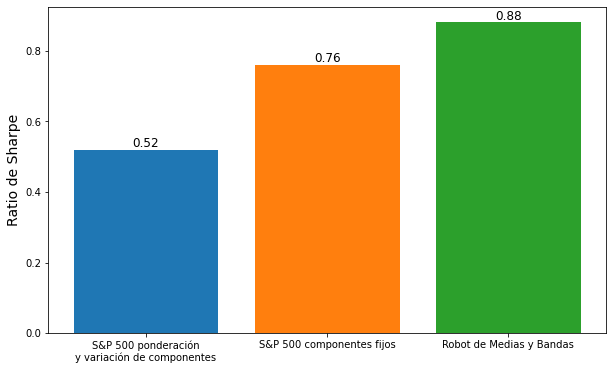

In [257]:
# Valores del Ratio de Sharpe
SR_SP500_variacion = 0.52
SR_SP500_fijo = 0.76
SR_MMBB = 0.88

# Nombres de las estrategias
estrategias = ["S&P 500 ponderación\ny variación de componentes", "S&P 500 componentes fijos", "Robot de Medias y Bandas"]

# Valores del Ratio de Sharpe
valores = [SR_SP500_variacion, SR_SP500_fijo, SR_MMBB]

# Crear el gráfico de barras
plt.figure(figsize=[10,6])
barras = plt.bar(estrategias, valores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Títulos y etiquetas
#plt.title('Comparación del Ratio de Sharpe de diferentes estrategias de trading', fontsize=16)
#plt.xlabel('Estrategias de Trading', fontsize=14)
plt.ylabel('Ratio de Sharpe', fontsize=14)

# Añadir etiquetas con los valores a las barras
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width() / 2, altura, f'{altura:.2f}', ha='center', va='bottom', fontsize=12)

# Mostrar el gráfico
plt.show()
